In [17]:
from brian2 import *

# Dendritic Spines


### notes on the cable equation

Brian is really trying to find the solution to this equation at each compartment

\begin{equation}
\frac{r_m}{r_l}  \frac{\partial^2 V}{\partial x^2} = c_m r_m \frac{\partial V}{\partial t} + V
\end{equation}

or rewritten,

\begin{equation}
\lambda^2  \frac{\partial^2 V}{\partial x^2} = \tau \frac{\partial V}{\partial t} + V
\end{equation}

where $\lambda$ is the space constant and $\tau$ is the time constant.

### on $R_i$
Remember that $R_T$ (R total) defined by Yuste is not the internal resistivity R_i which Brian takes as a parameter.
\begin{equation}
R_T [\Omega] = R_i \frac{L}{\pi a^2}
\end{equation} 

Therefore to get $R_i [\omega \text{cm}]$, we need to know the dimensions of the spine.

\begin{equation}
R_i = R_T \frac{\pi a^2}{L}
\end{equation}

R_i is typically on the order of 100 $[\Omega \text{cm}]$. For the measured value in Cornejo, 100 $M\Omega$, and assuming spine dimensions are on the order $~10^-4 cm (0.1 um)$ for the radius and the length, this gives us an $R_i ~ 10^4$ ohm cm which is two orders of magnitude higher than expected.

## Simulation Code

In [18]:
def default_params(**kwargs):
    p = {
    # morph
    'd_spine_head' : 0.4, #um
    'l_spine_neck' : 0.4, # um
    'd_spine_neck' : 0.1, # um
    'd_soma' : 30, # um
    'd_dendrite': 1, # um
    'l_dendrite' : 100, # um
    'n_neck' : 5,
    'n_dend' : 10,
    
    # sim
    'VK' : -70. * mV,
    'V_r' : -70. * mV, 
    'gl' : 0.3*msiemens/cm**2,
    'gK' : 1*siemens/meter**2,
    'g' : 3*siemens/meter**2,     # This is a conductance that I use when 'connecting' the voltages at between the spatial neurons.  The actual value is somewhat arbitrary.
    'El' : -70*mV,
    'Cm' :1*uF/cm**2, # specific membrane capacitance
    'Ri': 100*ohm*cm, # intracellular resistivity
    'Ri_neck' : 1e4*ohm*cm,
    'thres' : 'v > 0*mV',
    'ref' : 'v > -10*mV',
    'I_stim' : 1*nA
    }
    
    p.update(kwargs)
    
    return p

In [19]:
def run_sim_old(RNECK):
    start_scope()

    # Set the default time step
    defaultclock.dt = 0.01*ms

    # Base Params

    VK = -70. * mV
    V_reset = -70. * mV
    thres = 'v > 0*mV'
    ref = 'v > -10*mV'
    gl = 0.3*msiemens/cm**2
    El = -70*mV
    Cm=1*uF/cm**2 # specific membrane capacitance
    Ri=100*ohm*cm # intracellular resistivity


    # -----------------------------
    # Model Equations
    # -----------------------------

    eqs = '''
    Im = gl * (El-v) + v_prev * g : amp/meter**2
    v_prev : volt
    I : amp (point current)
    g : siemens/meter**2
    '''

    eqs_neck = '''
    Im = gl * (El-v) + v_prev * g + gK * (VK - v) : amp/meter**2
    v_prev : volt
    I : amp (point current)
    g : siemens/meter**2
    gK : siemens/meter**2
    '''

    eqs_head = '''
    Im = gl * (El-v): amp/meter**2
    I : amp (point current)
    g : siemens/meter**2
    gK : siemens/meter**2
    '''

    # Morphology Parameters
    d_spine_head = 0.4 # um
    l_spine_neck = 0.4 # um
    d_spine_neck = 0.1 # um

    d_soma = 30 # um
    d_dendrite = 1 # um
    l_dendrite = 100 # um


    # Create a morphology
    soma_morph = Soma(diameter = d_soma*um)
    soma_morph.dendrite = Cylinder(diameter = d_dendrite*um, length = l_dendrite*um, n = 5)
    neck_morph = Cylinder(diameter = d_spine_neck*um, length = l_spine_neck*um, n = 5)
    head_morph = Soma(diameter = d_spine_head*um)

    # Generate the neurons
    soma = SpatialNeuron(morphology=soma_morph, model=eqs, Cm=Cm, Ri=100*ohm*cm, threshold = thres, threshold_location=0, refractory = ref)
    neck = SpatialNeuron(morphology=neck_morph, model=eqs_neck, Cm=Cm, Ri=RNECK)
    head = SpatialNeuron(morphology=head_morph, model=eqs_head, Cm=Cm, Ri=100*ohm*cm)

    # Initial System Setup
    head.v = V_reset
    neck.v = V_reset
    soma.v = V_reset

    # This is a conductance that I use when 'connecting' the voltages at between the spatial neurons. 
    # The actual value is somewhat arbitrary.
    neck.g = 3*siemens/meter**2
    head.g = 3*siemens/meter**2
    soma.g = 3*siemens/meter**2

    # Set a constant gK for the spine neck
    neck.gK = 1*siemens/meter**2

    @network_operation
    def f(t):
        neck[4].v_prev = head.v
        soma[5].v_prev= neck[0].v


    #M_soma = StateMonitor(soma, ['v', 'I'], record=True)
    M_spine_head = StateMonitor(head, ['v', 'Im'], record=True)
    M_spine_neck = StateMonitor(neck, ['v', 'v_prev', 'Im'], record=True)
    M_soma = StateMonitor(soma, ['v', 'Im'], record = True)

    # Starting the simulation

    run(10*ms)
    head.I = 1 * nA # send an electric pulse
    run(0.02*ms)
    head.I = 0 * nA
    run(10*ms)

    return M_spine_head, M_spine_neck, M_soma


In [28]:
def run_sim(params, RNECK):
    start_scope()

    # Set the default time step
    defaultclock.dt = 0.01*ms

    # Simulation Parameters
    VK = params['VK']
    V_reset = params['V_r']
    thres = params['thres']
    ref = params['ref']
    gl = params['gl']
    gK = params['gK']
    g = params['g']
    El = params['El']
    Cm = params['Cm']
    Ri = params['Ri']
    I_stim = params['I_stim']
    
    # Morphology Parameters
    d_spine_head = params['d_spine_head'] # um
    l_spine_neck = params['l_spine_neck'] # um
    d_spine_neck = params['d_spine_neck'] # um
    d_soma = params['d_soma'] # um
    d_dendrite = params['d_dendrite'] # um
    l_dendrite = params['l_dendrite'] # um
    n_neck = params['n_neck']
    n_dend = params['n_dend']


    # -----------------------------
    # Model Equations
    # -----------------------------

    eqs = '''
    Im = gl * (El-v) + v_prev * g : amp/meter**2
    v_prev : volt
    I : amp (point current)
    g : siemens/meter**2
    '''

    eqs_neck = '''
    Im = gl * (El-v) + v_prev * g + gK * (VK - v) : amp/meter**2
    v_prev : volt
    I : amp (point current)
    g : siemens/meter**2
    gK : siemens/meter**2
    '''

    eqs_head = '''
    Im = gl * (El-v): amp/meter**2
    I : amp (point current)
    g : siemens/meter**2
    gK : siemens/meter**2
    '''

    # Create a morphology
    soma_morph = Soma(diameter = d_soma*um)
    soma_morph.dendrite = Cylinder(diameter = d_dendrite*um, length = l_dendrite*um, n = n_dend)
    neck_morph = Cylinder(diameter = d_spine_neck*um, length = l_spine_neck*um, n = n_neck)
    head_morph = Soma(diameter = d_spine_head*um)

    # Generate the neurons
    soma = SpatialNeuron(morphology=soma_morph, model=eqs, Cm=Cm, Ri=Ri, threshold = thres, threshold_location=0, refractory = ref)
    neck = SpatialNeuron(morphology=neck_morph, model=eqs_neck, Cm=Cm, Ri=RNECK)
    head = SpatialNeuron(morphology=head_morph, model=eqs_head, Cm=Cm, Ri=Ri)

    # Initial System Setup
    head.v = V_reset
    neck.v = V_reset
    soma.v = V_reset

    @network_operation
    def f(t):
        neck[4].v_prev = head.v
        soma[5].v_prev= neck[0].v

    # This is a conductance that I use when 'connecting' the voltages at between the spatial neurons. 
    # The actual value is somewhat arbitrary.
    neck.g = 3*siemens/meter**2
    head.g = 3*siemens/meter**2
    soma.g = 3*siemens/meter**2
    
        # Set a constant gK for the spine neck
    neck.gK = 1*siemens/meter**2


    #M_soma = StateMonitor(soma, ['v', 'I'], record=True)
    M_spine_head = StateMonitor(head, ['v', 'Im'], record=True)
    M_spine_neck = StateMonitor(neck, ['v', 'v_prev', 'Im'], record=True)
    M_soma = StateMonitor(soma, ['v', 'Im'], record = True)

    # Starting the simulation

    run(20*ms)
    head.I = 1*nA # send an electric pulse
    run(0.02*ms)
    head.I = 0 * nA
    run(10*ms)

    return M_spine_head, M_spine_neck, M_soma


# Voltage across compartments

Plotted below are the voltages over time for the simulation at 10 ms. The head+neck and soma+dendrite are plotted separately. Note that the dendrite and soma both have 5 compartments.

In [21]:
M_spine_head, M_spine_neck, M_soma = run_sim(default_params())

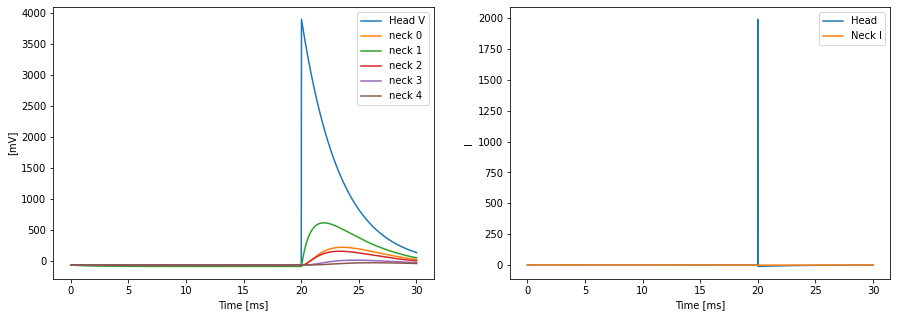

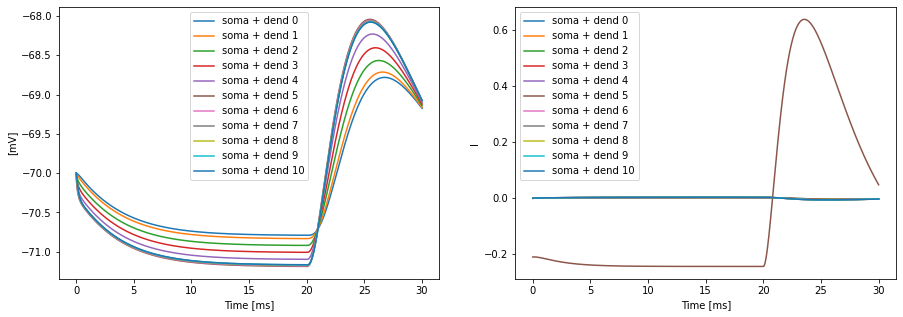

In [29]:
fig, axs = plt.subplots(1,2, figsize = (15,5))
axs[0].plot(M_spine_head.t/ms, M_spine_head.v[0]/mV, label = 'Head V')
for idx, item in enumerate(M_spine_neck):
    axs[0].plot(item.t/ms, item.v/mV, label = 'neck ' + str(idx))
axs[0].legend()
axs[0].set_xlabel('Time [ms]')
axs[0].set_ylabel('[mV]')

axs[1].plot(M_spine_head.t/ms, M_spine_head.Im[0], label = 'Head')
axs[1].plot(M_spine_neck.t/ms, M_spine_neck.Im[0], label = 'Neck I')    
axs[1].set_xlabel('Time [ms]')
axs[1].set_ylabel('I')
axs[1].legend()

fig, axs = plt.subplots(1,2, figsize = (15,5))
for idx, item in enumerate(M_soma):
    axs[0].plot(M_soma.t/ms, item.v/mV, label = 'soma + dend ' + str(idx))
    axs[1].plot(M_soma.t/ms, item.Im, label = 'soma + dend ' + str(idx))
axs[0].legend()
axs[0].set_xlabel('Time [ms]')
axs[0].set_ylabel('[mV]')
axs[1].set_xlabel('Time [ms]')
axs[1].set_ylabel('I')
axs[1].legend()

In [ ]:
def EPSP(monitor):
    t = monitor.t/ms
    v = monitor.v/mV
    return np.max(v) - v[np.where(t<10)[0][-1]]

### Varying resistance

The length constant $\lambda = \sqrt{\frac{r_m}{r_i}}$ is inversely proportional to $R_i$. The effect on voltage decreases as resistance is increased.

WARNING    'gK' is an internal variable of group 'spatialneuron_6', but also exists in the run namespace with the value 1. * siemens / (meter ** 2). The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'g' is an internal variable of group 'spatialneuron', but also exists in the run namespace with the value 3. * siemens / (meter ** 2). The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'g' is an internal variable of group 'spatialneuron_3', but also exists in the run namespace with the value 3. * siemens / (meter ** 2). The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'gK' is an internal variable of group 'spatialneuron_3', but also exists in the run namespace with the value 1. * siemens / (meter ** 2). The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Text(0.5, 1.0, 'EPSP at the Soma')

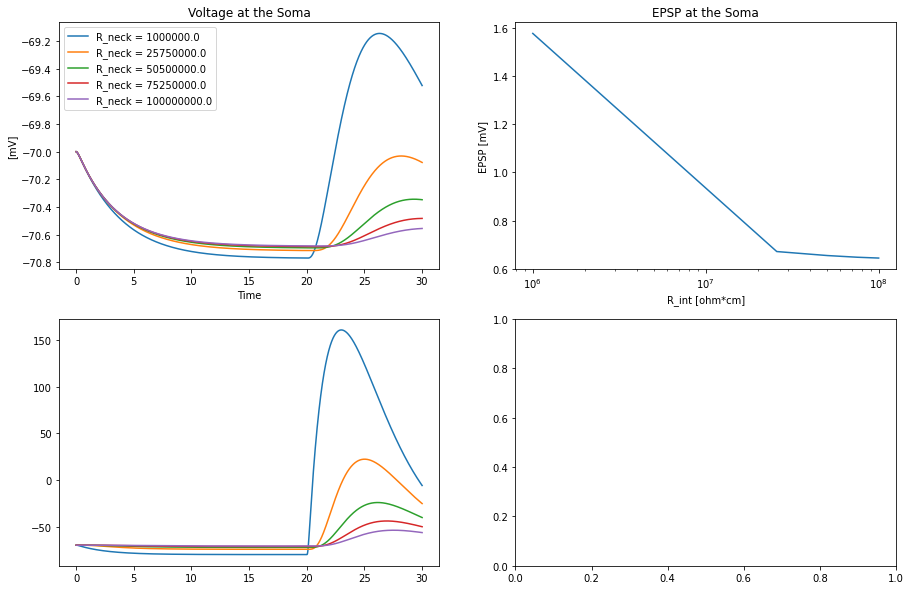

In [30]:
R_VALS = np.linspace(1e6, 1e8, 5)
EPSPs = np.zeros(len(R_VALS))

fig, axs = plt.subplots(2,2, figsize = (15, 10))

for idx,r in enumerate(R_VALS):
    #M_spine_head, M_spine_neck, M_soma = run_sim_old(r*ohm*cm)
    M_spine_head, M_spine_neck, M_soma = run_sim(default_params(), r*ohm*cm)
    axs[0][0].plot(M_soma[0].t/ms, M_soma[0].v/mV, label = "R_neck = " + str(r))
    axs[1][0].plot(M_spine_neck[0].t/ms, M_spine_neck[0].v/mV, label = "R_neck = " + str(r))

    EPSPs[idx] = EPSP(M_soma[0])

axs[0][1].plot(R_VALS, EPSPs)
axs[0][1].set_xscale('log')
axs[0][0].legend()

axs[0][0].set_ylabel("[mV]")
axs[0][0].set_xlabel("Time")
axs[0][0].set_title("Voltage at the Soma")
axs[0][1].set_ylabel("EPSP [mV]")
axs[0][1].set_xlabel("R_int [ohm*cm]")
axs[0][1].set_title("EPSP at the Soma")

### Increasing gk

This should be equivalent to opening up the channels.

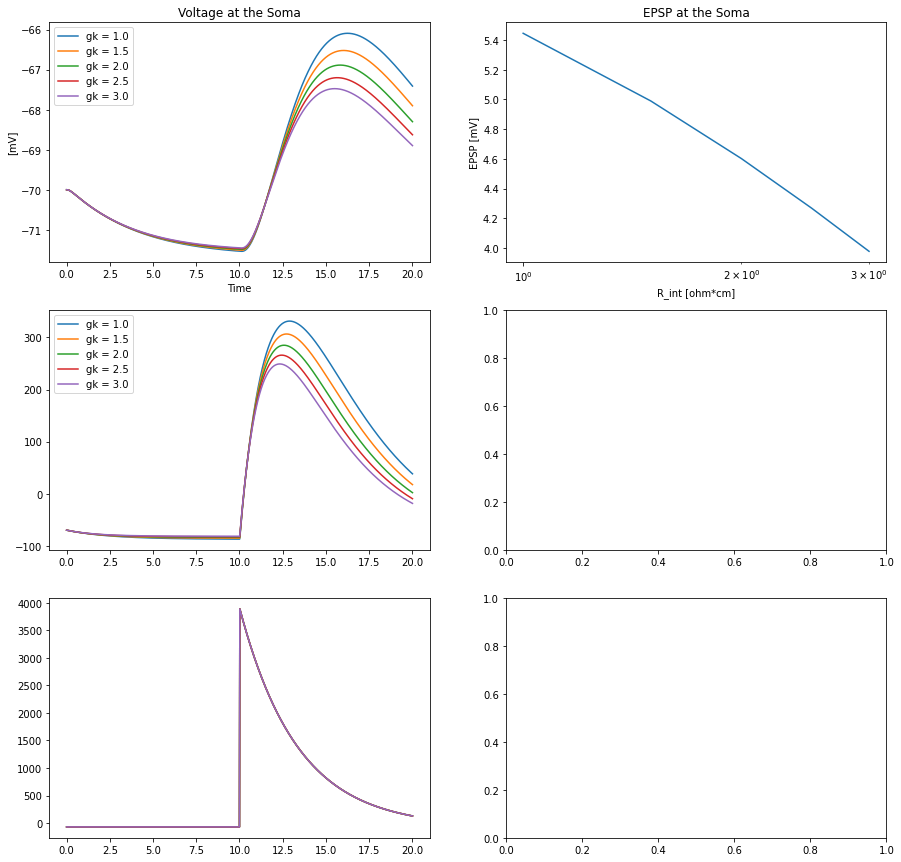

In [ ]:
gk_vals = np.linspace(1, 3, 5)
EPSPs = np.zeros(len(gk_vals))

fig, axs = plt.subplots(3,2, figsize = (15, 15))

for idx,gk in enumerate(gk_vals):
    M_spine_head, M_spine_neck, M_soma = run_sim(1e4*ohm*cm, gk)
    axs[0][0].plot(M_soma[0].t/ms, M_soma[0].v/mV, label = "gk = " + str(gk))
    axs[1][0].plot(M_spine_neck[0].t/ms, M_spine_neck[0].v/mV, label = "gk = " + str(gk))
    axs[2][0].plot(M_spine_head[0].t/ms, M_spine_head[0].v/mV, label = "gk = " + str(gk))
    
    EPSPs[idx] = EPSP(M_soma[0])

axs[0][1].plot(gk_vals, EPSPs)
axs[0][1].set_xscale('log')
axs[0][0].legend()

axs[0][0].set_ylabel("[mV]")
axs[0][0].set_xlabel("Time")
axs[0][0].set_title("Voltage at the Soma")
axs[0][1].set_ylabel("EPSP [mV]")
axs[0][1].set_xlabel("R_int [ohm*cm]")
axs[0][1].set_title("EPSP at the Soma")
axs[1][0].legend()

### Delta EPSP vs Resistance

Text(0, 0.5, 'deltaEPSP/EPSP')

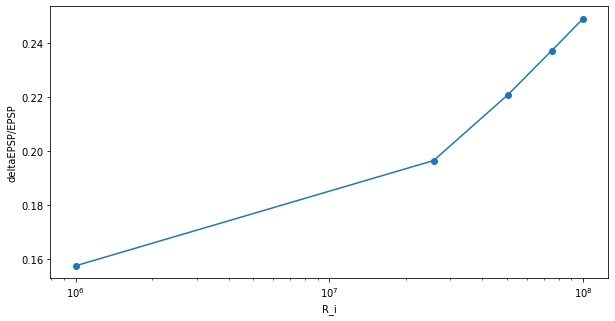

In [ ]:
R_VALS = np.linspace(1e6, 1e8, 5)
deltaEPSP = np.zeros(len(R_VALS))

fig, axs = plt.subplots(figsize = (10, 5))

for idx,r in enumerate(R_VALS):
    M_spine_head_1, M_spine_neck_1, M_soma_1 = run_sim(r*ohm*cm, 1)
    M_spine_head_2, M_spine_neck_2, M_soma_2 = run_sim(r*ohm*cm, 2)
    deltaEPSP[idx] = (EPSP(M_soma_1[0]) - EPSP(M_soma_2[0]))/EPSP(M_soma_1[0])
axs.scatter(R_VALS, deltaEPSP)
axs.plot(R_VALS, deltaEPSP)
axs.set_xscale('log')
axs.set_xlabel('R_i')
axs.set_ylabel('deltaEPSP/EPSP')